# Handwritten Digit Recognition

This tutorial guides you through a classic computer vision application: identify hand written digits with neural networks. 

## Load data

We first fetch the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which is a commonly used dataset for handwritten digit recognition. Each image in this dataset has been resized into 28x28 with grayscale value between 0 and 254. The following codes download and load the images and the according labels into `numpy`.

In [1]:
import numpy as np
import os
import urllib
import gzip
import struct
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

We plot the first 10 images and print their labels. 

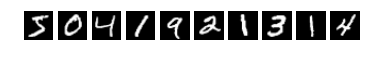

label: [5 0 4 1 9 2 1 3 1 4]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

Next we create data iterators for MXNet. The data iterator, which is similar the iterator, returns a batch of data in each `next()` call. A batch contains several images with its according labels. These images are stored in a 4-D matrix with shape `(batch_size, num_channels, width, height)`. For the MNIST dataset, there is only one color channel, and both width and height are 28. In addition, we often shuffle the images used for training, which accelerates the training progress.

In [3]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

## Multilayer Perceptron

A multilayer perceptron contains several fully-connected layers. For a fully-connected layer, assume the input matrix $X$ has size $n\times m$, then it outputs matrix $Y$ with size $n\times k$, where $k$ is often called as the hidden size. This layer has two parameters, the $m \times k$ weight matrix $W$ and the $m\times 1$ bias vector $b$. It compute the outputs by

$$Y = W X + b.$$

The output of a fully-connected layer is often feed into an activation layer, which performs elemental-wise operations. The widely known function is sigmoid, which has form $f(x) = 1/(1+e^{-x})$. Nowadays people also use a simpler function called relu: $f(x) = max(0,x)$.  

The last fully-connected layer often has the hidden size equals to the number of classes in the dataset. Then we stack a softmax layer, which map the input into a probability score. Again assume the input $X$ has size $n\times m$, and $x_i$ is the i-th row. Then the i-th row of the output is 

$$ \left[\frac{\exp(x_{i1})}{\sum_{j=1}^m \exp(x_{ij})},\ldots, \frac{\exp(x_{im})}{\sum_{j=1}^m \exp(x_{ij})}\right] $$

Define the multilayer perceptron in MXNet is straightforward, which has shown as following.

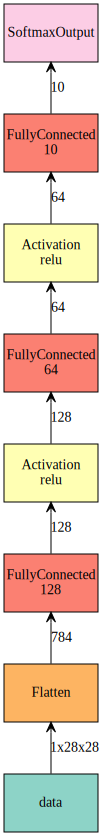

In [4]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

Now both the network definition and data iterators are ready. We can start training. 

In [5]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
) 

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 25096.62 samples/sec	Train-accuracy=0.113300
INFO:root:Epoch[0] Batch [400]	Speed: 21358.65 samples/sec	Train-accuracy=0.114450
INFO:root:Epoch[0] Batch [600]	Speed: 21343.26 samples/sec	Train-accuracy=0.144800
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=2.681
INFO:root:Epoch[0] Validation-accuracy=0.276100
INFO:root:Epoch[1] Batch [200]	Speed: 21342.33 samples/sec	Train-accuracy=0.418450
INFO:root:Epoch[1] Batch [400]	Speed: 21264.81 samples/sec	Train-accuracy=0.751150
INFO:root:Epoch[1] Batch [600]	Speed: 20331.59 samples/sec	Train-accuracy=0.829600
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=2.869
INFO:root:Epoch[1] Validation-accuracy=0.856600
INFO:root:Epoch[2] Batch [200]	Speed: 21282.05 samples/sec	Train-accuracy=0.860550
INFO:root:Epoch[2] Batch [400]	Speed: 21283.09 samples/sec	Train-accuracy=0.883200
INFO:root:Epoch[2] Batch [600]	Speed: 21257.8

After training is done, we can predict a single image. 

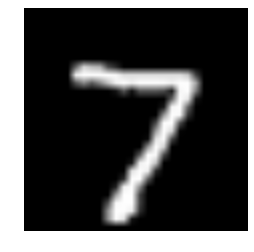

Classified as 7 with probability 0.999818


In [7]:
plt.imshow(val_img[0], cmap='Greys_r')
plt.axis('off')
plt.show()
prob = model.predict(val_img[0:1].astype(np.float32)/255)[0]
print 'Classified as %d with probability %f' % (prob.argmax(), max(prob))

We can also evaluate the accuracy by given a data iterator. 

In [8]:
print 'Validation accuracy: %f%%' % (model.score(val_iter)*100,)

Validation accuracy: 96.630000%


Even more, we can recognizes the digit written on the below box. 

In [9]:
from IPython.display import HTML
import cv2
import numpy as np
def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = cv2.imdecode(np.fromstring(img, np.uint8), -1)
    img = cv2.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1,1,28,28))/255.0
    return model.predict(img)[0].argmax()

html = """<style type="text/css">canvas { border: 1px solid black; }</style><div id="board"><canvas id="myCanvas" width="100px" height="100px">Sorry, your browser doesn't support canvas technology.</canvas><p><button id="classify" onclick="classify()">Classify</button><button id="clear" onclick="myClear()">Clear</button>Result: <input type="text" id="result_output" size="5" value=""></p></div>"""
script = """<script type="text/JavaScript" src="https://ajax.googleapis.com/ajax/libs/jquery/1.4.2/jquery.min.js?ver=1.4.2"></script><script type="text/javascript">function init() {var myCanvas = document.getElementById("myCanvas");var curColor = $('#selectColor option:selected').val();if(myCanvas){var isDown = false;var ctx = myCanvas.getContext("2d");var canvasX, canvasY;ctx.lineWidth = 8;$(myCanvas).mousedown(function(e){isDown = true;ctx.beginPath();var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.moveTo(canvasX, canvasY);}).mousemove(function(e){if(isDown != false) {var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.lineTo(canvasX, canvasY);ctx.strokeStyle = curColor;ctx.stroke();}}).mouseup(function(e){isDown = false;ctx.closePath();});}$('#selectColor').change(function () {curColor = $('#selectColor option:selected').val();});}init();function handle_output(out) {document.getElementById("result_output").value = out.content.data["text/plain"];}function classify() {var kernel = IPython.notebook.kernel;var myCanvas = document.getElementById("myCanvas");data = myCanvas.toDataURL('image/png');document.getElementById("result_output").value = "";kernel.execute("classify('" + data +"')",  { 'iopub' : {'output' : handle_output}}, {silent:false});}function myClear() {var myCanvas = document.getElementById("myCanvas");myCanvas.getContext("2d").clearRect(0, 0, myCanvas.width, myCanvas.height);}</script>"""
HTML(html+script)

## Convolutional Neural Networks

Note that the previous fully-connected layer simply reshapes the image into a vector during training. It ignores the spatial information that pixels are correlated on both horizontal and vertical dimensions. The convolutional layer aims to improve this drawback by using a more structural weight $W$. Instead of simply matrix-matrix multiplication, it uses 2-D convolution to obtain the output. 

Besides the convolutional layer, another major change of the convolutional neural network is the adding of pooling layers. A pooling layer reduce a $n\times m$ (often called kernal size) image patch into a single value to make the network less sensitive to the spatial location. 

Defining a convolutional neural network in MXNet is also straightforward. The following codes define the famous LeNet:

In [10]:
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

Training is similar as before. But note that LeNet is more complex than the previous multilayer perceptron, here we use GPU instead of CPU for training. 

In [11]:
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 

INFO:root:Start training with [gpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 20385.38 samples/sec	Train-accuracy=0.113750
INFO:root:Epoch[0] Batch [400]	Speed: 23314.51 samples/sec	Train-accuracy=0.114450
INFO:root:Epoch[0] Batch [600]	Speed: 23305.92 samples/sec	Train-accuracy=0.108300
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=2.960
INFO:root:Epoch[0] Validation-accuracy=0.113500
INFO:root:Epoch[1] Batch [200]	Speed: 23369.62 samples/sec	Train-accuracy=0.154900
INFO:root:Epoch[1] Batch [400]	Speed: 23243.68 samples/sec	Train-accuracy=0.779100
INFO:root:Epoch[1] Batch [600]	Speed: 23228.94 samples/sec	Train-accuracy=0.914550
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=2.585
INFO:root:Epoch[1] Validation-accuracy=0.936200
INFO:root:Epoch[2] Batch [200]	Speed: 23404.30 samples/sec	Train-accuracy=0.943000
INFO:root:Epoch[2] Batch [400]	Speed: 23247.41 samples/sec	Train-accuracy=0.956000
INFO:root:Epoch[2] Batch [600]	Speed: 23265.1

Note that, with the same hyper-parameters, LeNet achieves 98.7% validation accuracy, which improves the previous multilayer perceptron accuracy 96.6%. Now we can try the previous handwritten digit demo again to check whether or not this model is actually better. 